# SEGMENTACION DE CLIENTES CON TARJETA DE CREDITO

###  >> Dicccionario de variables:

***CUST_ID:*** Identificación del titular de la tarjeta de crédito

***BALANCE:*** Saldo promedio mensual (basado en promedios de saldo diario)

***BALANCE_FREQUENCY:*** Relación de los últimos 12 meses con saldo

***PURCHASES:*** Importe total de la compra gastada durante los últimos 12 meses

***ONEOFF_PURCHASES:*** Importe total de la compra gastada durante los últimos 12 meses

***INSTALLMENTS_PURCHASES:*** Monto total de compras a plazos

***CASH_ADVANCE:*** Importe total del anticipo en efectivo

***PURCHASES_ FREQUENCY:*** Frecuencia de compras (Porcentaje de meses con al menos una compra)

***ONEOFF_PURCHASES_FREQUENCY:*** Frecuencia de compras únicas

***PURCHASES_INSTALLMENTS_FREQUENCY***: Frecuencia de compras a plazos

***CASH_ADVANCE_ FREQUENCY:*** Frecuencia de anticipos en efectivo

***AVERAGE_PURCHASE_TRX:*** Monto promedio por transacción de compra

***CASH_ADVANCE_TRX:*** Monto promedio por transacción de anticipo en efectivo

***PURCHASES_TRX:*** Monto por transacción

***CREDIT_LIMIT:*** Limite de crédito

***PAYMENTS:*** Pagos totales (monto adeuda pagado por el cliente para disminuir el saldo de su estado de cuenta) en el período

***MINIMUM_PAYMENTS:*** Pagos mínimos totales adeudados en el período

***PRC_FULL_PAYMEN:*** Porcentaje de meses con pago total del saldo adeudado

***TENURE:*** Número de meses como cliente

##  >> Importando las librerías

In [1]:
# Nativos
import random as rn
import os
import sys
import gc

#calculo
import numpy as np
import pandas as pd
import scipy
from scipy import stats


#grafico
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from IPython.display import display_html
%matplotlib inline
sns.set(style="whitegrid")

#Interacciones con output
import warnings
warnings.filterwarnings("ignore")
# warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

gc.collect()

BASE_DIR = os.path.dirname(os.getcwd())
if BASE_DIR not in sys.path: sys.path.append(BASE_DIR)

#from utils import *
#from graphs import *

SEED = 29082013
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
rn.seed(SEED)

#subfolder = "data"
# os.listdir(subfolder)

## >> Utilitarios

In [2]:
def MahalanobisDist(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            vars_mean = []
            for i in range(data.shape[0]):
                vars_mean.append(list(data.mean(axis=0)))
            diff = data - vars_mean
            md = []
            for i in range(len(diff)):
                md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))

            if verbose:
                print("Covariance Matrix:\n {}\n".format(covariance_matrix))
                print("Inverse of Covariance Matrix:\n {}\n".format(inv_covariance_matrix))
                print("Variables Mean Vector:\n {}\n".format(vars_mean))
                print("Variables - Variables Mean Vector:\n {}\n".format(diff))
                print("Mahalanobis Distance:\n {}\n".format(md))
            return md
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")


def MD_detectOutliers(data, extreme=False, verbose=False):
    MD = MahalanobisDist(data, verbose)
    # one popular way to specify the threshold
    #m = np.mean(MD)
    #t = 3. * m if extreme else 2. * m
    #outliers = []
    #for i in range(len(MD)):
    #    if MD[i] > t:
    #        outliers.append(i)  # index of the outlier
    #return np.array(outliers)

    # or according to the 68–95–99.7 rule
    std = np.std(MD)
    k = 3. * std if extreme else 2. * std
    m = np.mean(MD)
    up_t = m + k
    low_t = m - k
    outliers = []
    for i in range(len(MD)):
        if (MD[i] >= up_t) or (MD[i] <= low_t):
            outliers.append(i)  # index of the outlier
    return np.array(outliers)


def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False
    
def null_verificator(data):        
    if data.isnull().any().any():
        view_info = pd.DataFrame(
            pd.concat(
                [data.isnull().any(), 
                 data.isnull().sum(),
                 data.dtypes], 
                axis=1)
        )
        view_info.columns = ['Nulos', 'Cantidad', 'Tipo Col']
        size = data.shape[0]
        view_info['Porcentaje'] = view_info['Cantidad'].apply(
            lambda x: np.round(0 if not x else x*100 / size, 2))
        return view_info
    else:
        return pd.DataFrame.from_dict({'msje':"DATA LIMPIA DE NULOS"}, orient='index')

## >> Cargando los datos

In [3]:
credit = pd.read_csv("comportamiento_tc.csv")
credit.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [4]:
credit.shape

(8950, 18)

## >> Informaicón general

In [5]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

## >> Analisis descriptivo

In [6]:
# Descripción inicial de los datos
credit.describe(percentiles=[0.01,.1, .3, 0.5, 0.7, 0.9, 0.99]).T

,count,mean,std,min,1%,10%,30%,50%,70%,90%,99%,max
BALANCE,8950.0,1564.474828,2081.531879,0.000000,0.065101,23.575529,207.176552,873.385231,1698.588855,4338.563657,9338.804814,19043.13856
BALANCE_FREQUENCY,8950.0,0.877271,0.236904,0.000000,0.090909,0.454545,0.909091,1.000000,1.000000,1.000000,1.000000,1.00000
PURCHASES,8950.0,1003.204834,2136.634782,0.000000,0.000000,0.000000,89.285000,361.280000,894.316000,2542.624000,8977.290000,49039.57000
ONEOFF_PURCHASES,8950.0,592.437371,1659.887917,0.000000,0.000000,0.000000,0.000000,38.000000,400.155000,1600.099000,6689.898200,40761.25000
INSTALLMENTS_PURCHASES,8950.0,411.067645,904.338115,0.000000,0.000000,0.000000,0.000000,89.000000,371.139000,1140.070000,3886.240500,22500.00000
CASH_ADVANCE,8950.0,978.871112,2097.163877,0.000000,0.000000,0.000000,0.000000,0.000000,797.272297,3065.534560,9588.163357,47137.21176
PURCHASES_FREQUENCY,8950.0,0.490351,0.401371,0.000000,0.000000,0.000000,0.083333,0.500000,0.857143,1.000000,1.000000,1.00000
ONEOFF_PURCHASES_FREQUENCY,8950.0,0.202458,0.298336,0.000000,0.000000,0.000000,0.000000,0.083333,0.222222,0.750000,1.000000,1.00000
PURCHASES_INSTALLMENTS_FREQUENCY,8950.0,0.364437,0.397448,0.000000,0.000000,0.000000,0.000000,0.166667,0.666667,1.000000,1.000000,1.00000
CASH_ADVANCE_FREQUENCY,8950.0,0.135144,0.200121,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.416667,0.833333,1.50000


## >> Detección de nulos

In [7]:
null_verificator(credit)

,Nulos,Cantidad,Tipo Col,Porcentaje
CUST_ID,False,0,object,0.00
BALANCE,False,0,float64,0.00
BALANCE_FREQUENCY,False,0,float64,0.00
PURCHASES,False,0,float64,0.00
ONEOFF_PURCHASES,False,0,float64,0.00
INSTALLMENTS_PURCHASES,False,0,float64,0.00
CASH_ADVANCE,False,0,float64,0.00
PURCHASES_FREQUENCY,False,0,float64,0.00
ONEOFF_PURCHASES_FREQUENCY,False,0,float64,0.00
PURCHASES_INSTALLMENTS_FREQUENCY,False,0,float64,0.00


In [8]:
if 'CUST_ID' in credit.columns:
    del credit['CUST_ID']

## >> Tratamientos de nulos

In [9]:
credit['MINIMUM_PAYMENTS'].describe()

count     8637.000000
mean       864.206542
std       2372.446607
min          0.019163
25%        169.123707
50%        312.343947
75%        825.485459
max      76406.207520
Name: MINIMUM_PAYMENTS, dtype: float64

In [10]:
indices_nulos_min_payments = credit[credit['MINIMUM_PAYMENTS'].isnull()].index
len(indices_nulos_min_payments)

313

In [11]:
from sklearn.impute import KNNImputer

knn_imp = KNNImputer(n_neighbors=3)
credit = pd.DataFrame(knn_imp.fit_transform(credit), columns=credit.columns)

In [12]:
null_verificator(credit)

,0
msje,DATA LIMPIA DE NULOS


In [13]:
credit.iloc[indices_nulos_min_payments]['MINIMUM_PAYMENTS'].describe()

count      313.000000
mean       580.674372
std       1656.789195
min          9.644271
25%         89.057424
50%        140.536647
75%        292.980844
max      16128.831462
Name: MINIMUM_PAYMENTS, dtype: float64

## >> Detección de outlier univariado

<AxesSubplot:xlabel='BALANCE'>

<AxesSubplot:xlabel='BALANCE_FREQUENCY'>

<AxesSubplot:xlabel='PURCHASES'>

<AxesSubplot:xlabel='ONEOFF_PURCHASES'>

<AxesSubplot:xlabel='INSTALLMENTS_PURCHASES'>

<AxesSubplot:xlabel='CASH_ADVANCE'>

<AxesSubplot:xlabel='PURCHASES_FREQUENCY'>

<AxesSubplot:xlabel='ONEOFF_PURCHASES_FREQUENCY'>

<AxesSubplot:xlabel='PURCHASES_INSTALLMENTS_FREQUENCY'>

<AxesSubplot:xlabel='CASH_ADVANCE_FREQUENCY'>

<AxesSubplot:xlabel='CASH_ADVANCE_TRX'>

<AxesSubplot:xlabel='PURCHASES_TRX'>

<AxesSubplot:xlabel='CREDIT_LIMIT'>

<AxesSubplot:xlabel='PAYMENTS'>

<AxesSubplot:xlabel='MINIMUM_PAYMENTS'>

<AxesSubplot:xlabel='PRC_FULL_PAYMENT'>

<AxesSubplot:xlabel='TENURE'>

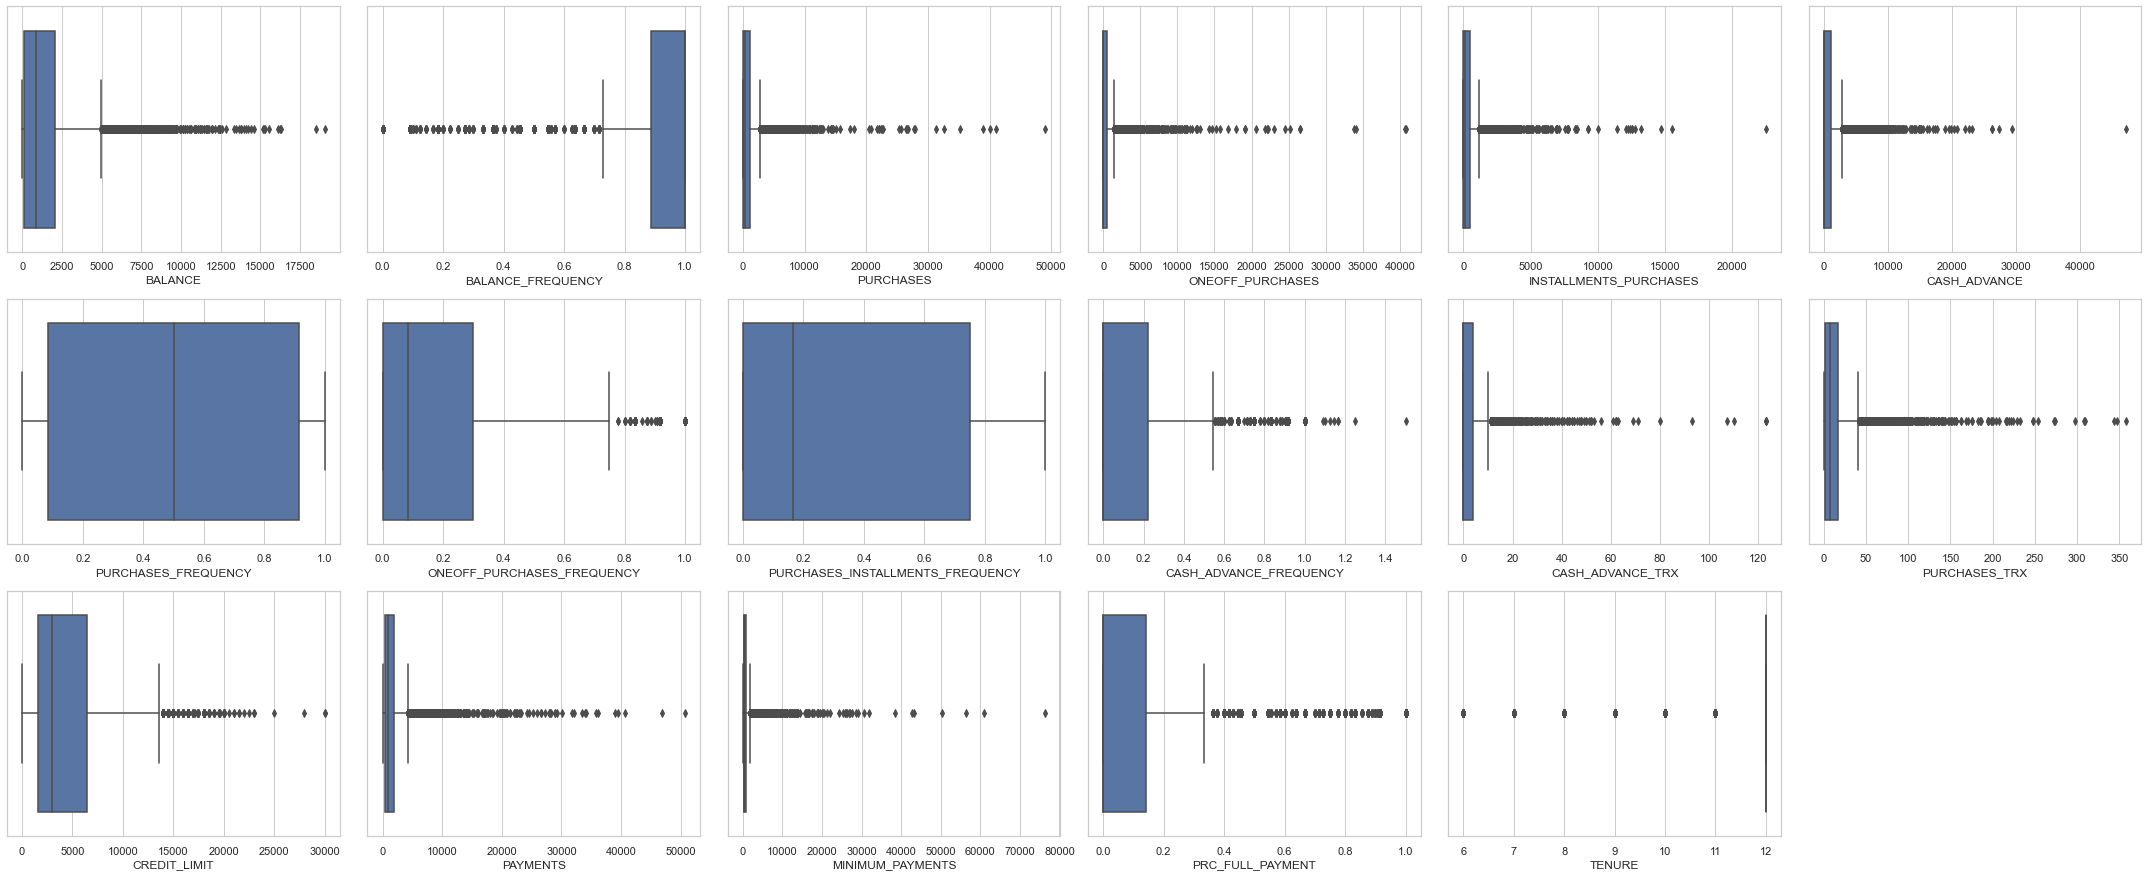

In [14]:
fig = plt.figure(figsize=(30, 20))
for idx, col in enumerate(credit.columns, 1):
    ax = fig.add_subplot(5, 6, idx)
    sns.boxplot(x=credit[col], ax=ax)

plt.tight_layout()

## >> Detección de ouliers multivariados

In [18]:
%%time

outliers_indices = MD_detectOutliers(credit.values, verbose=True)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [19]:
n_ouliers_multivariados = len(outliers_indices)
n_ouliers_multivariados

220

In [26]:
credit.iloc[list(outliers_indices)].describe().T

,count,mean,std,min,25%,50%,75%,max
BALANCE,220.0,4998.025523,4222.742316,0.000000,1622.713836,3899.494024,7183.673137,19043.13856
BALANCE_FREQUENCY,220.0,0.912793,0.204210,0.000000,1.000000,1.000000,1.000000,1.00000
PURCHASES,220.0,6185.342000,8995.950012,0.000000,186.355000,1779.705000,9163.127500,49039.57000
ONEOFF_PURCHASES,220.0,3787.634318,7452.031778,0.000000,0.000000,307.355000,3161.830000,40761.25000
INSTALLMENTS_PURCHASES,220.0,2408.414955,3642.972822,0.000000,0.000000,641.850000,3533.285000,22500.00000
CASH_ADVANCE,220.0,4644.655869,7125.319713,0.000000,0.000000,680.141872,7062.442512,47137.21176
PURCHASES_FREQUENCY,220.0,0.614174,0.417208,0.000000,0.089015,0.833333,1.000000,1.00000
ONEOFF_PURCHASES_FREQUENCY,220.0,0.342931,0.382538,0.000000,0.000000,0.166667,0.666667,1.00000
PURCHASES_INSTALLMENTS_FREQUENCY,220.0,0.511822,0.439774,0.000000,0.000000,0.583333,1.000000,1.00000
CASH_ADVANCE_FREQUENCY,220.0,0.281594,0.356694,0.000000,0.000000,0.083333,0.500000,1.50000


## >> Eliminación de oulier multivariados

In [27]:
print(credit.shape)

credit = credit.loc[~credit.index.isin(list(outliers_indices))].reset_index(drop=True)

print(credit.shape)

(8950, 17)
(8730, 17)


## >> Suavizamiento de valores extremos

In [28]:
for idx, col in enumerate(credit.columns, 1):
    print(idx, col)
    percentil_95 = credit[col].quantile(0.95)
    maximo = credit[col].max()
    print("---------------- percentil 99%: ", round(percentil_95, 2), 'máximo: ', round(maximo, 2), 'relacion máximo/percentil 95: ',maximo/percentil_95)
    
    if maximo/percentil_95 >= 1.5:
        credit[col] = credit[col].apply(lambda _: percentil_95 if _ > percentil_95 else _)

1 BALANCE
---------------- percentil 99%:  5615.83 máximo:  14224.12 relacion máximo/percentil 95:  2.532860899741333
2 BALANCE_FREQUENCY
---------------- percentil 99%:  1.0 máximo:  1.0 relacion máximo/percentil 95:  1.0
3 PURCHASES
---------------- percentil 99%:  3606.34 máximo:  14454.98 relacion máximo/percentil 95:  4.008216091810602
4 ONEOFF_PURCHASES
---------------- percentil 99%:  2481.23 máximo:  11246.07 relacion máximo/percentil 95:  4.532448558882976
5 INSTALLMENTS_PURCHASES
---------------- percentil 99%:  1621.91 máximo:  6158.27 relacion máximo/percentil 95:  3.79691524951385
6 CASH_ADVANCE
---------------- percentil 99%:  4340.86 máximo:  13748.47 relacion máximo/percentil 95:  3.1672215565023065
7 PURCHASES_FREQUENCY
---------------- percentil 99%:  1.0 máximo:  1.0 relacion máximo/percentil 95:  1.0
8 ONEOFF_PURCHASES_FREQUENCY
---------------- percentil 99%:  1.0 máximo:  1.0 relacion máximo/percentil 95:  1.0
9 PURCHASES_INSTALLMENTS_FREQUENCY
---------------- pe

<AxesSubplot:xlabel='BALANCE'>

<AxesSubplot:xlabel='BALANCE_FREQUENCY'>

<AxesSubplot:xlabel='PURCHASES'>

<AxesSubplot:xlabel='ONEOFF_PURCHASES'>

<AxesSubplot:xlabel='INSTALLMENTS_PURCHASES'>

<AxesSubplot:xlabel='CASH_ADVANCE'>

<AxesSubplot:xlabel='PURCHASES_FREQUENCY'>

<AxesSubplot:xlabel='ONEOFF_PURCHASES_FREQUENCY'>

<AxesSubplot:xlabel='PURCHASES_INSTALLMENTS_FREQUENCY'>

<AxesSubplot:xlabel='CASH_ADVANCE_FREQUENCY'>

<AxesSubplot:xlabel='CASH_ADVANCE_TRX'>

<AxesSubplot:xlabel='PURCHASES_TRX'>

<AxesSubplot:xlabel='CREDIT_LIMIT'>

<AxesSubplot:xlabel='PAYMENTS'>

<AxesSubplot:xlabel='MINIMUM_PAYMENTS'>

<AxesSubplot:xlabel='PRC_FULL_PAYMENT'>

<AxesSubplot:xlabel='TENURE'>

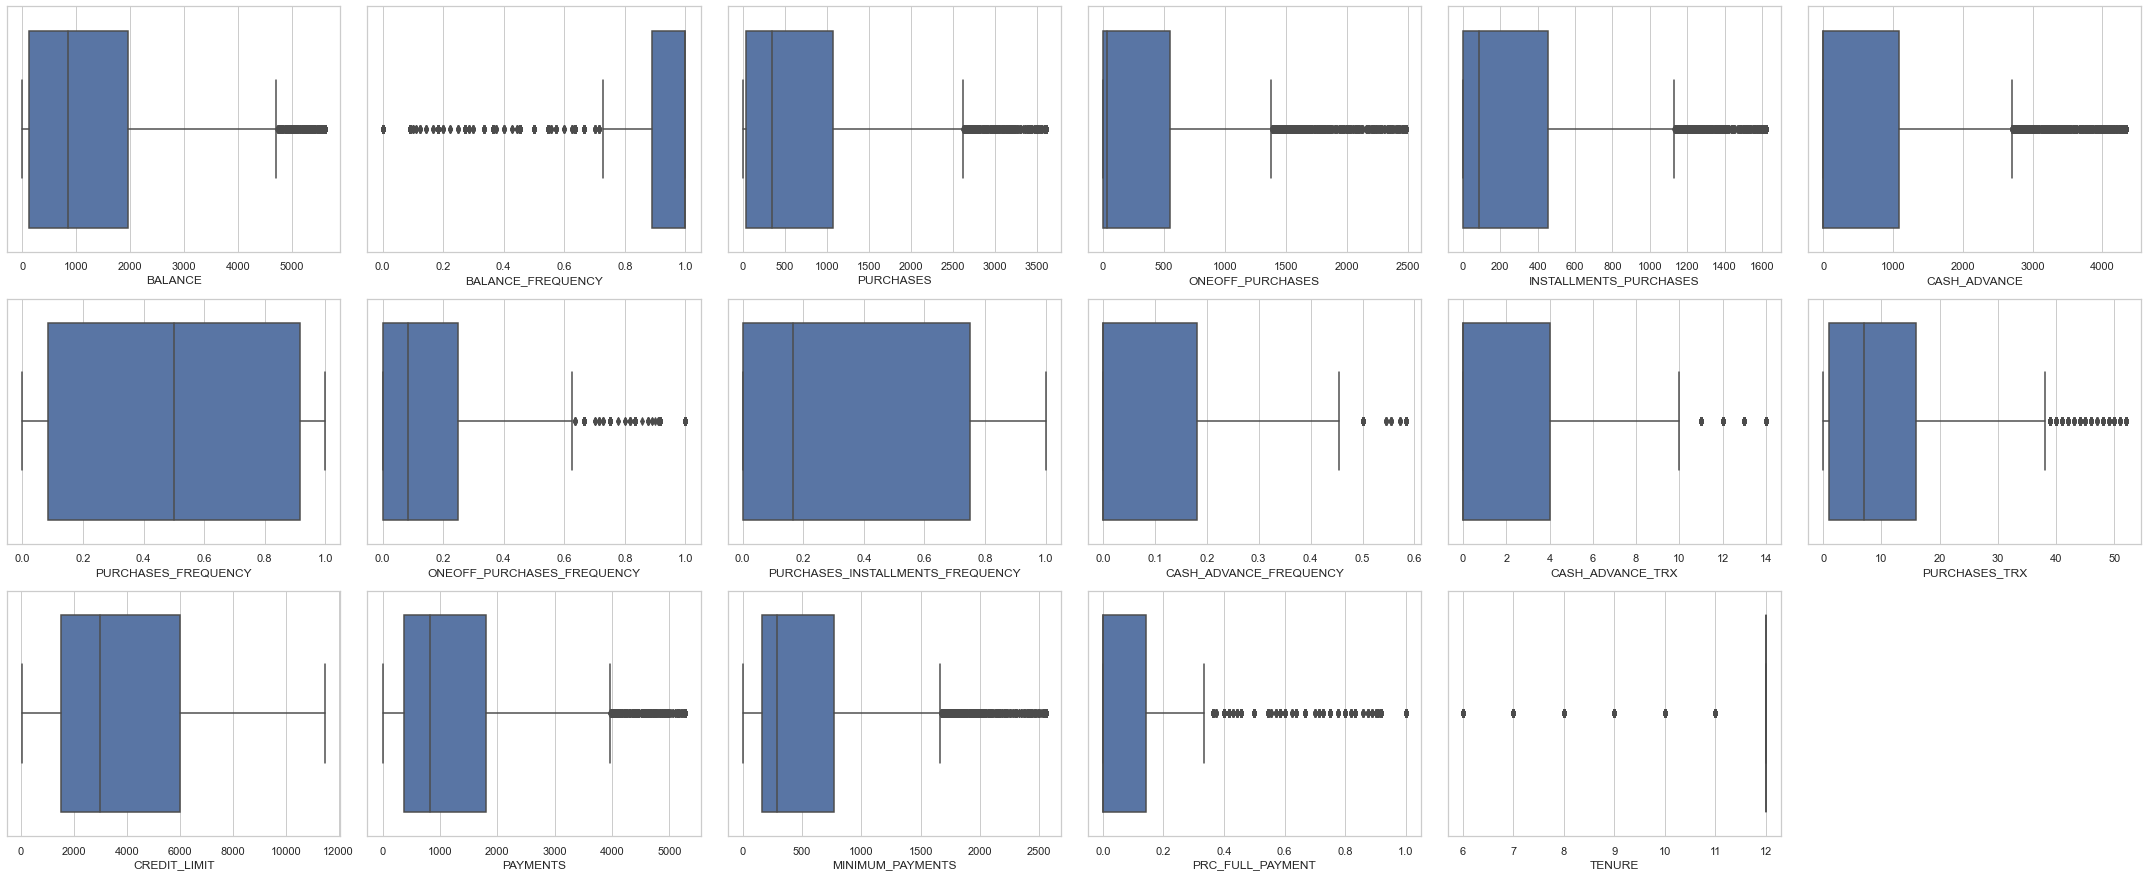

In [29]:
fig = plt.figure(figsize=(30, 20))
for idx, col in enumerate(credit.columns, 1):
    ax = fig.add_subplot(5, 6, idx)
    sns.boxplot(x=credit[col], ax=ax)

plt.tight_layout()

## >> Análisis de correlaciones 

<Figure size 1224x720 with 0 Axes>

<AxesSubplot:>

Text(5, 3, '')

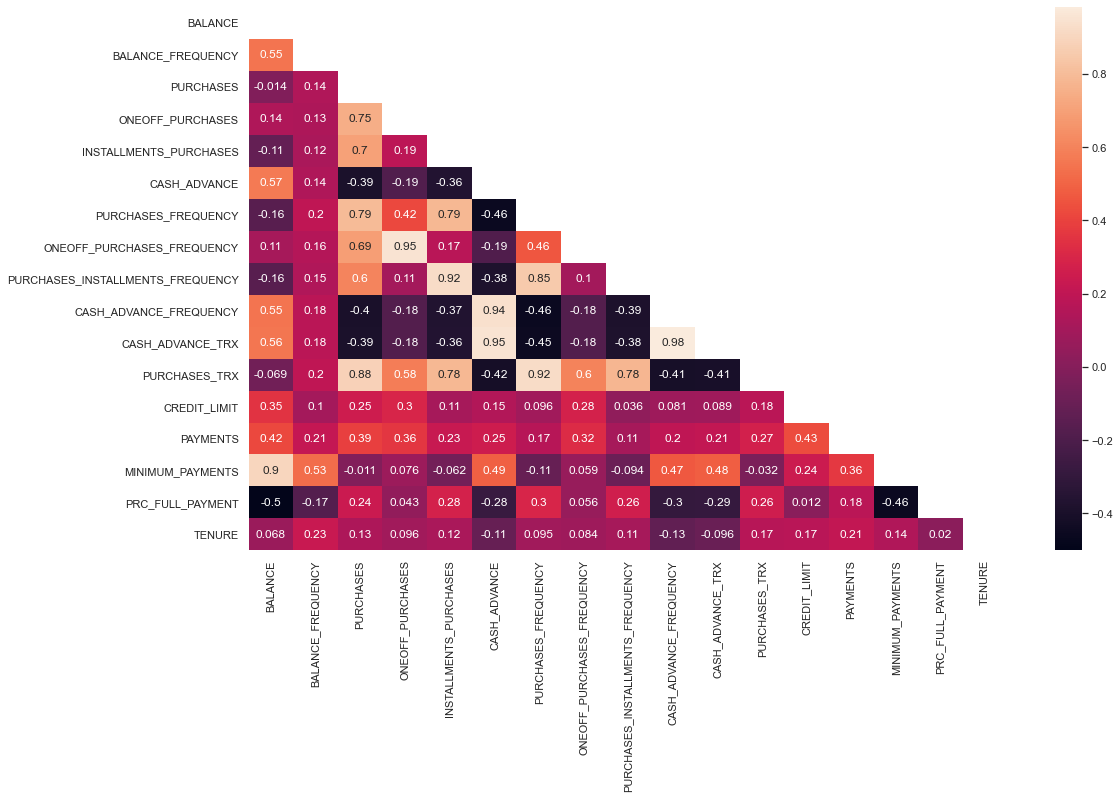

In [30]:
corr = credit.corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(17, 10))
sns.heatmap(corr, mask=mask, annot=True)
text = """"""
plt.text(5, 3, text, size=13)
plt.show()

## >> Escalamiento por proporción 

In [31]:
from sklearn.preprocessing import  StandardScaler
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler

In [33]:
sc = MinMaxScaler()

In [34]:
cr_scaled = sc.fit_transform(credit)

In [37]:
type(cr_scaled)

numpy.ndarray

## >> Applying PCA

**Con la ayuda del análisis de componentes principales reduciremos características**

In [38]:
from sklearn.decomposition import PCA
cr_scaled.shape

(8730, 17)

**Varianza explicada acorde al número de componentes**

In [40]:
var_ratio = {}

for n in range(1,15):
    pc = PCA(n_components=n)
    cr_pca = pc.fit(cr_scaled)
    var_ratio[n] = sum(cr_pca.explained_variance_ratio_)

var_ratio

{1: 0.3613608376877753,
 2: 0.5749446897403341,
 3: 0.681219451240309,
 4: 0.7467601475472354,
 5: 0.7995176136848399,
 6: 0.8376326496145985,
 7: 0.8718738034801947,
 8: 0.9018432825075768,
 9: 0.925357857763832,
 10: 0.9470179913788008,
 11: 0.9609985073999774,
 12: 0.9739962414522831,
 13: 0.9833390762387875,
 14: 0.9908123368215893}

***Seleccionamos 4 componentes que explican 74% > 70% recomendado***

Text(0, 0.5, 'Varianza explicada')

Text(0.5, 0, 'Número de componentes')

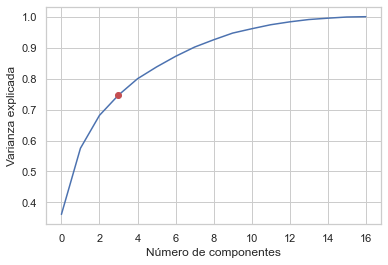

In [42]:
pca_test = PCA().fit(cr_scaled)
plt.plot(pca_test.explained_variance_ratio_.cumsum())
plt.plot([4-1], [0.746], 'ro')
plt.ylabel('Varianza explicada')
plt.xlabel('Número de componentes')

# the following plot tells us the variance we manage to get aganist the number of dimensions.

In [43]:
pca_2d = PCA(n_components=4)
Xn_2d = pca_2d.fit_transform(cr_scaled)
normalize_Xs_because = PCA(n_components=7).fit_transform(cr_scaled)

In [44]:
Xn_2d.shape

(8730, 4)

## >> Obteniendo componentes

In [46]:
dd = pd.DataFrame(Xn_2d)
dd.head()

,0,1,2,3
0,-0.468057,-0.630652,0.087687,-0.167729
1,-0.839553,0.680075,0.028571,0.202323
2,0.337820,0.099805,0.615552,-0.386643
3,-0.350106,-0.086364,0.585648,-0.226581
4,-0.548124,-0.495715,0.183570,-0.251416


<AxesSubplot:xlabel='0'>

<AxesSubplot:xlabel='1'>

<AxesSubplot:xlabel='2'>

<AxesSubplot:xlabel='3'>

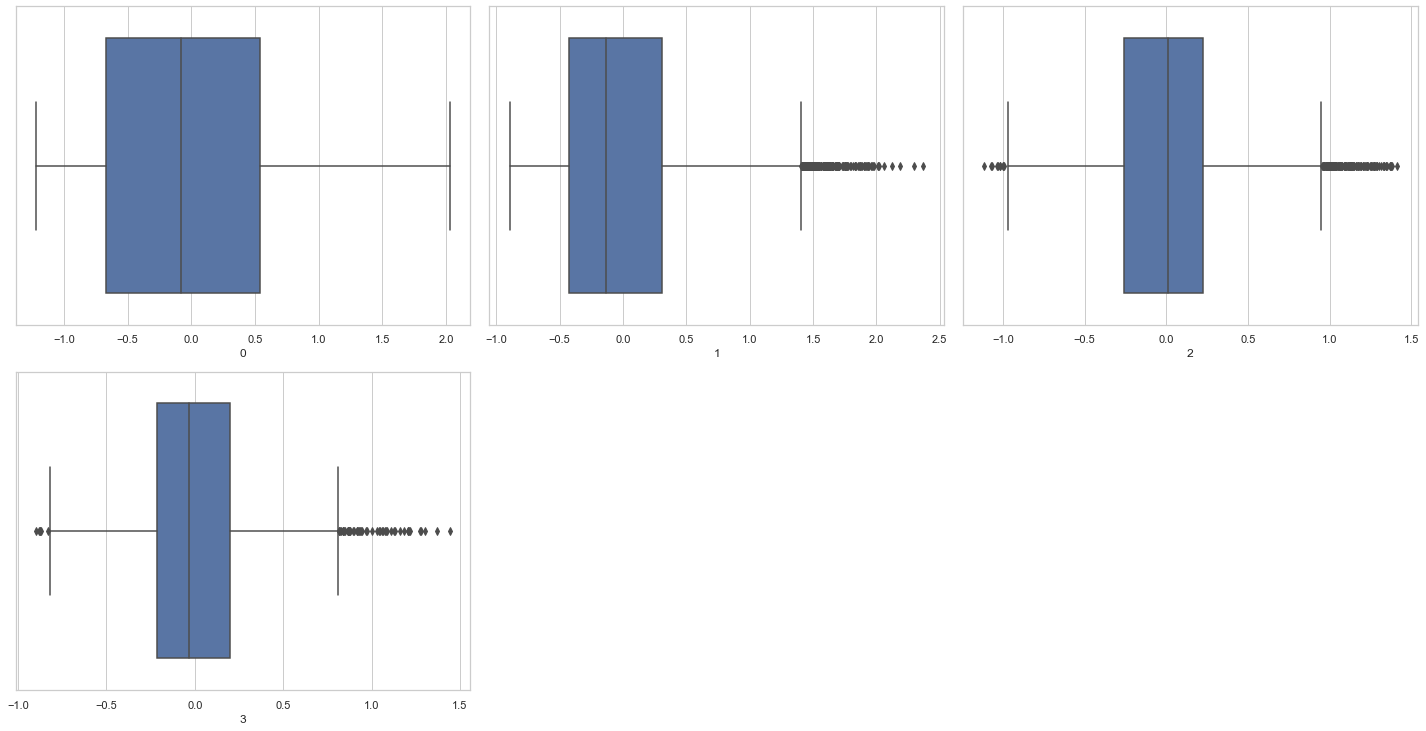

In [47]:
fig = plt.figure(figsize=(20, 20))
for idx, col in enumerate(dd.columns, 1):
    ax = fig.add_subplot(4, 3, idx)
    sns.boxplot(x=dd[col], ax=ax)

plt.tight_layout()

<Figure size 1224x720 with 0 Axes>

<AxesSubplot:>

Text(5, 3, '')

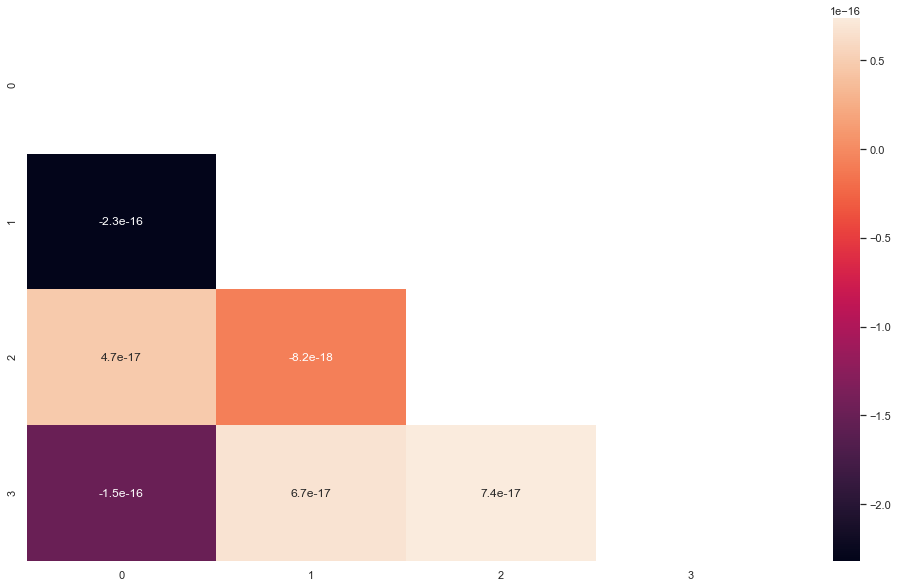

In [48]:
corr = dd.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(17, 10))
sns.heatmap(corr, mask=mask, annot=True)
text = """"""
plt.text(5, 3, text, size=13)
plt.show()

## Analisis cluster con K-Means

In [53]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
dicc_kmeans = {
    'init': 'k-means++',
    'random_state': SEED,
    'n_init': 20
}

def metodo_codo(data_cluster, max_cluster):
    range_n_clusters = range(2, max_cluster)
    inertias = []

    for n_clusters in range_n_clusters:
        modelo_kmeans = KMeans(n_clusters=n_clusters, **dicc_kmeans)
        modelo_kmeans.fit(data_cluster)
        inertias.append(modelo_kmeans.inertia_)

    fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))

    ax.plot(range_n_clusters, inertias, marker='o')
    ax.set_title("Evolución de la varianza intra-cluster (ratio + intervalo)")
    ax.set_xlabel('Número clusters')
    ax.set_ylabel('Intra-cluster (inertia)')
    
    
def metodo_silueta(data, max_cluster):
    valores_medios_silhouette = []
    range_n_clusters = range(2, max_cluster)
    
    for n_clusters in range_n_clusters:
        modelo_kmeans = KMeans(n_clusters=n_clusters, **dicc_kmeans)
        cluster_labels = modelo_kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        valores_medios_silhouette.append(silhouette_avg)

    fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
    
    ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
    ax.set_title("Evolución de media de los índices silhouette")
    ax.set_xlabel('Número clusters')
    ax.set_ylabel('Media índices silhouette')

***El método del codo nos indica claramente el uso de 4 cluster***

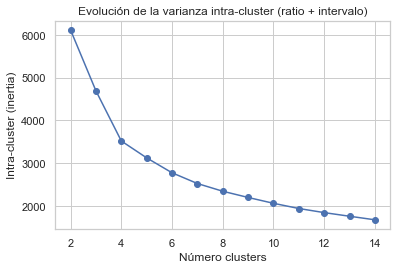

In [54]:
metodo_codo(dd, 15)

***Y de igual manera con 4 cluster se obtiene el valor mas alto de la silueta***

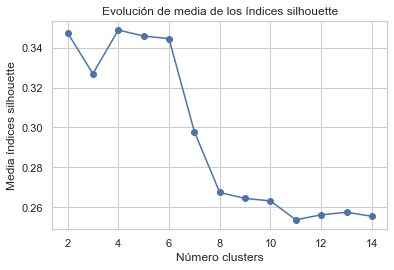

In [55]:
metodo_silueta(dd, 15)

In [57]:
n_select = 4

In [58]:
kmeans = KMeans(n_clusters=n_select, **dicc_kmeans).fit(dd)
clusters = kmeans.labels_

pd.DataFrame({"Customers": credit.index, "Clusters": clusters})
credit["cluster_kmeans"] = clusters
credit.head()

,Customers,Clusters
0,0,1
1,1,3
2,2,0
3,3,1
4,4,1
...,...,...
8725,8725,2
8726,8726,2
8727,8727,2
8728,8728,1


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster_kmeans
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0.0,2.0,1000.0,201.802084,139.509787,0.000000,12.0,1
1,3202.467416,0.909091,0.00,0.00,0.0,4340.861877,0.000000,0.000000,0.000000,0.250000,4.0,0.0,7000.0,4103.032597,1072.340217,0.222222,12.0,3
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,12.0,7500.0,622.066742,627.284787,0.000000,12.0,0
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1.0,1.0,7500.0,0.000000,448.208854,0.000000,12.0,1
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0.0,1.0,1200.0,678.334763,244.791237,0.000000,12.0,1


## >> Revisión de cantidad por cluster

In [60]:
credit["cluster_kmeans"] = credit["cluster_kmeans"] + 1

credit.groupby("cluster_kmeans").agg(
    {"cluster_kmeans": "count"}
)

,cluster_kmeans
cluster_kmeans,
1,1370
2,3555
3,2262
4,1543


In [61]:
credit.groupby("cluster_kmeans").agg(np.mean)

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
cluster_kmeans,,,,,,,,,,,,,,,,,
1,1842.448272,0.977103,2595.390620,1657.406004,796.771321,444.557104,0.918810,0.698173,0.631435,0.070800,1.489051,35.712409,6643.052422,2763.064947,695.613649,0.264954,11.894161
2,871.996448,0.784865,287.720415,234.270366,51.573551,389.872539,0.200525,0.122358,0.076910,0.083230,1.396906,3.430380,3211.209734,808.830501,401.909038,0.089459,11.484669
3,613.734626,0.903936,769.645126,134.550416,599.334146,175.986802,0.871525,0.085783,0.810927,0.038291,0.701149,16.627321,3183.859930,889.625961,439.921986,0.267854,11.438550
4,3280.134871,0.957375,282.282552,187.175852,92.045221,2819.173561,0.201229,0.097880,0.114268,0.398535,9.206092,4.190538,5931.446022,2100.685610,1195.106696,0.030540,11.370706


<Figure size 2520x360 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'BALANCE    \nCluster 1 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'BALANCE    \nCluster 2 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'BALANCE    \nCluster 3 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'BALANCE    \nCluster 4 ')

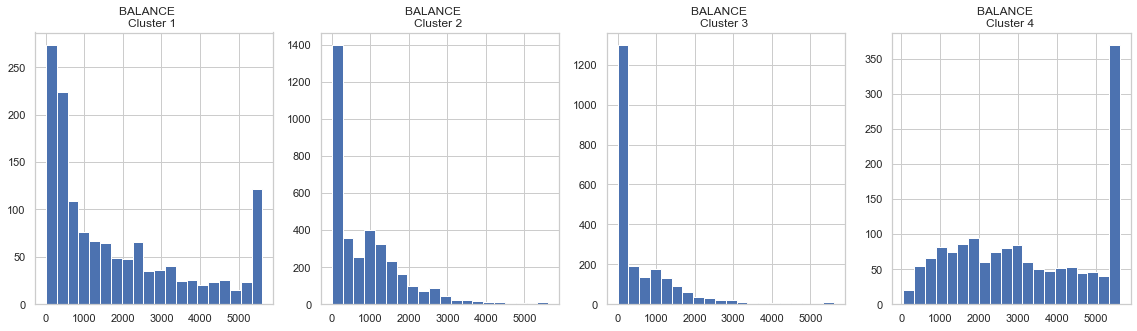

<Figure size 2520x360 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'BALANCE_FREQUENCY    \nCluster 1 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'BALANCE_FREQUENCY    \nCluster 2 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'BALANCE_FREQUENCY    \nCluster 3 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'BALANCE_FREQUENCY    \nCluster 4 ')

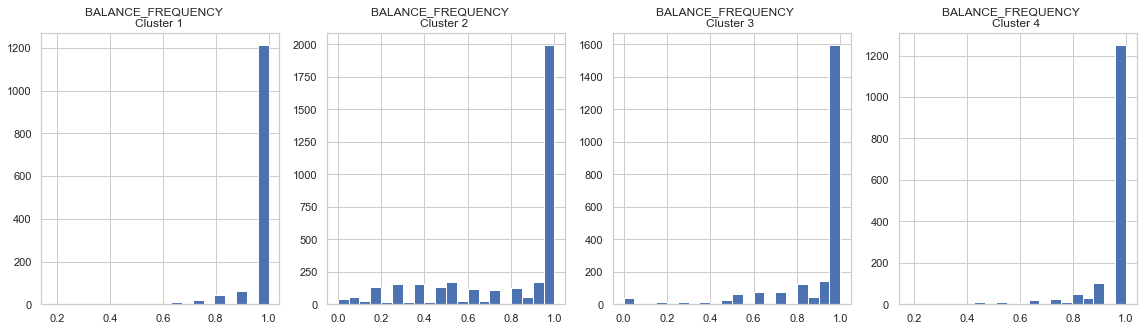

<Figure size 2520x360 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'PURCHASES    \nCluster 1 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'PURCHASES    \nCluster 2 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'PURCHASES    \nCluster 3 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'PURCHASES    \nCluster 4 ')

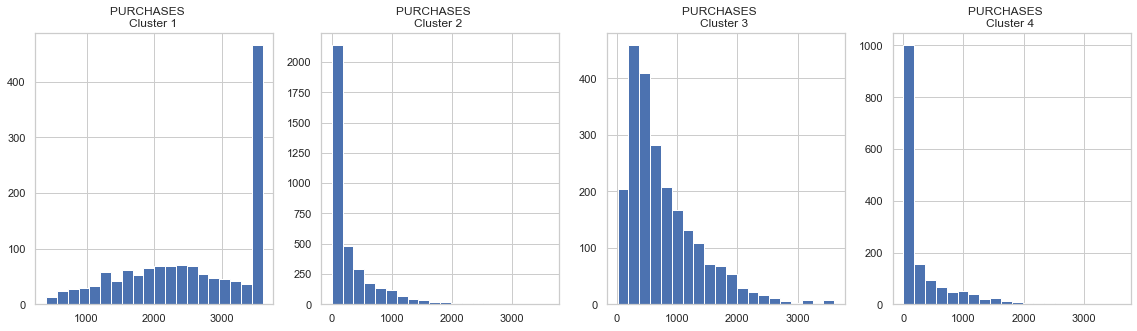

<Figure size 2520x360 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'ONEOFF_PURCHASES    \nCluster 1 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'ONEOFF_PURCHASES    \nCluster 2 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'ONEOFF_PURCHASES    \nCluster 3 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'ONEOFF_PURCHASES    \nCluster 4 ')

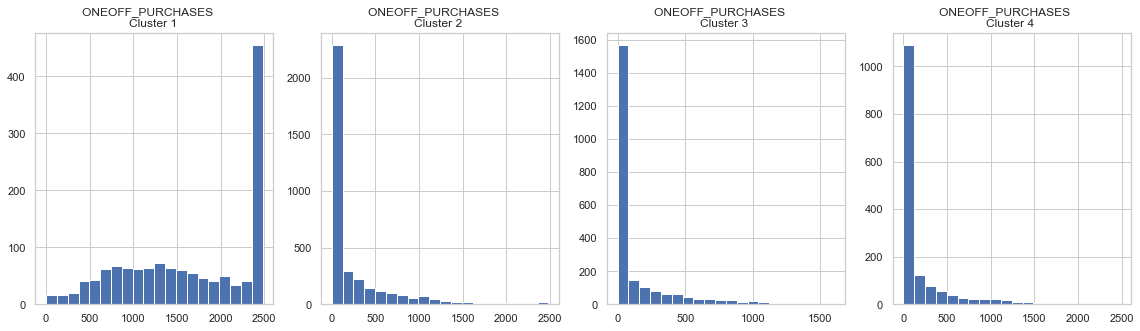

<Figure size 2520x360 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'INSTALLMENTS_PURCHASES    \nCluster 1 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'INSTALLMENTS_PURCHASES    \nCluster 2 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'INSTALLMENTS_PURCHASES    \nCluster 3 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'INSTALLMENTS_PURCHASES    \nCluster 4 ')

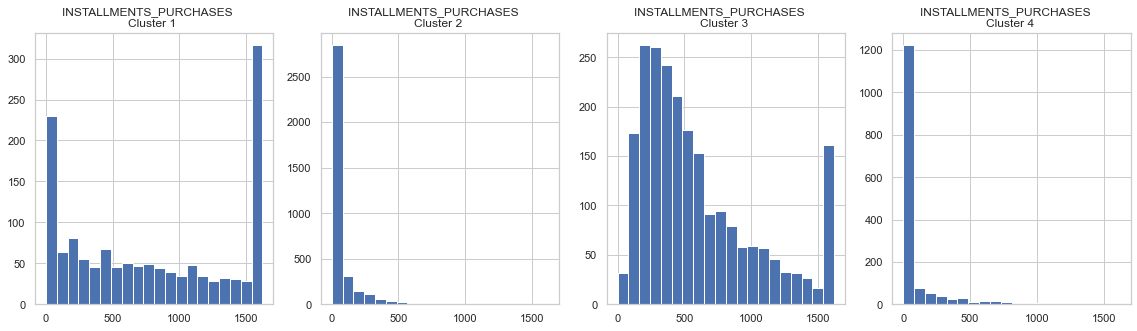

<Figure size 2520x360 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'CASH_ADVANCE    \nCluster 1 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'CASH_ADVANCE    \nCluster 2 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'CASH_ADVANCE    \nCluster 3 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'CASH_ADVANCE    \nCluster 4 ')

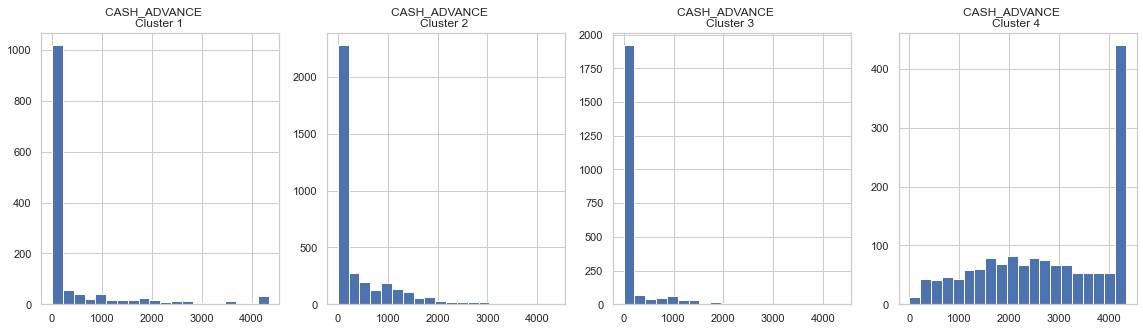

<Figure size 2520x360 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'PURCHASES_FREQUENCY    \nCluster 1 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'PURCHASES_FREQUENCY    \nCluster 2 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'PURCHASES_FREQUENCY    \nCluster 3 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'PURCHASES_FREQUENCY    \nCluster 4 ')

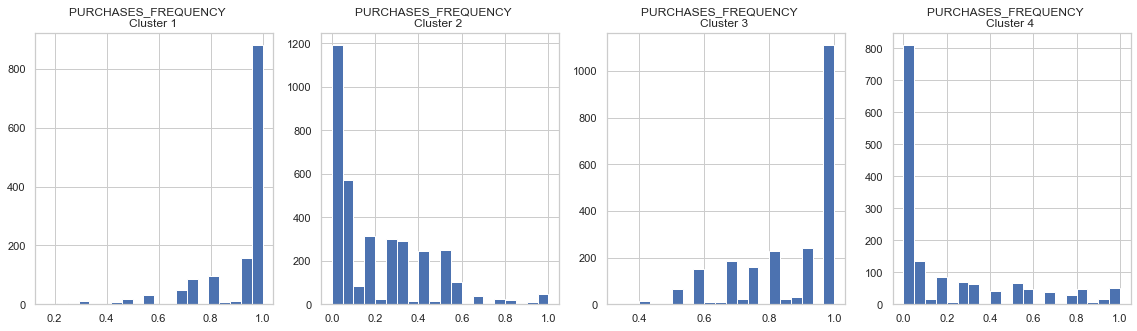

<Figure size 2520x360 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'ONEOFF_PURCHASES_FREQUENCY    \nCluster 1 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'ONEOFF_PURCHASES_FREQUENCY    \nCluster 2 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'ONEOFF_PURCHASES_FREQUENCY    \nCluster 3 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'ONEOFF_PURCHASES_FREQUENCY    \nCluster 4 ')

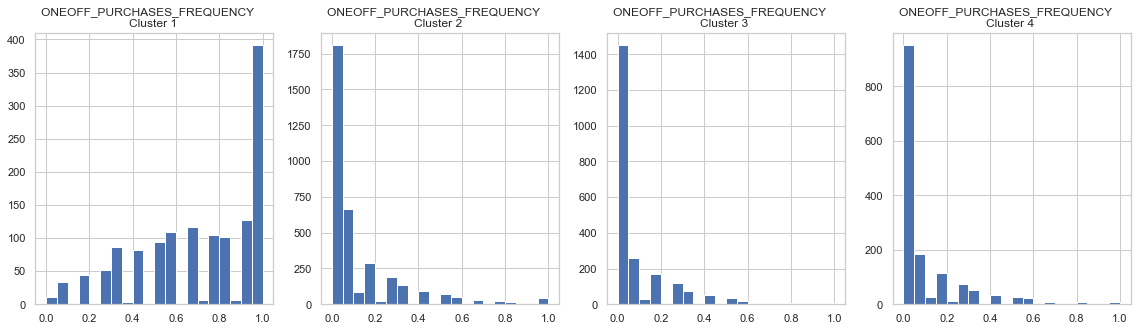

<Figure size 2520x360 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'PURCHASES_INSTALLMENTS_FREQUENCY    \nCluster 1 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'PURCHASES_INSTALLMENTS_FREQUENCY    \nCluster 2 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'PURCHASES_INSTALLMENTS_FREQUENCY    \nCluster 3 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'PURCHASES_INSTALLMENTS_FREQUENCY    \nCluster 4 ')

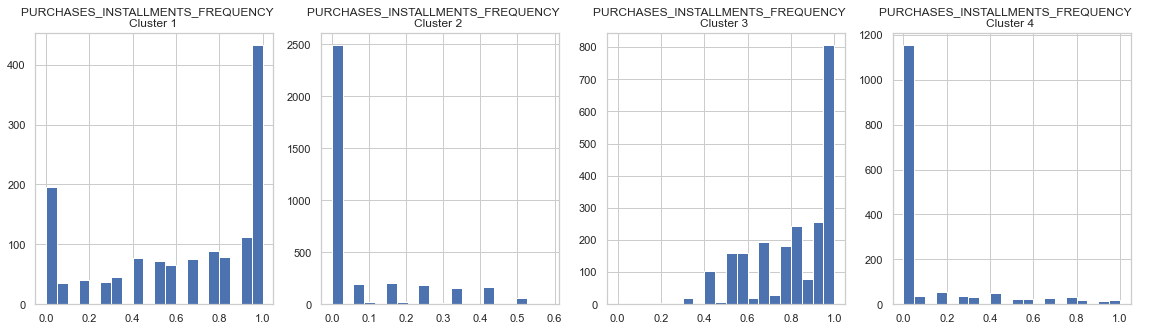

<Figure size 2520x360 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'CASH_ADVANCE_FREQUENCY    \nCluster 1 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'CASH_ADVANCE_FREQUENCY    \nCluster 2 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'CASH_ADVANCE_FREQUENCY    \nCluster 3 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'CASH_ADVANCE_FREQUENCY    \nCluster 4 ')

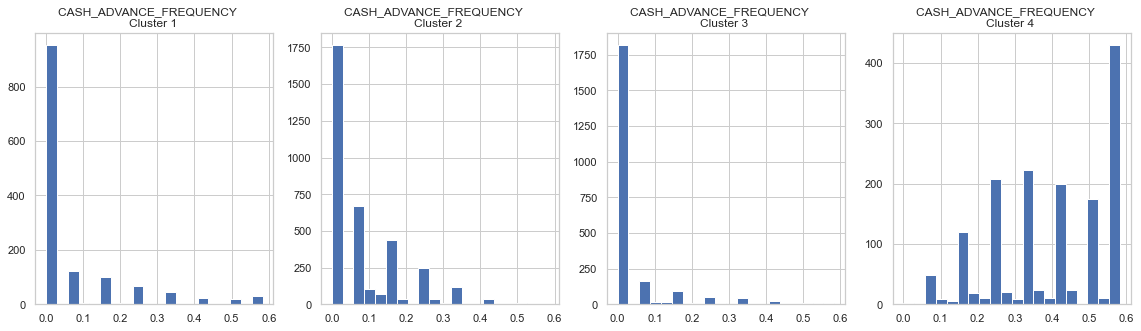

<Figure size 2520x360 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'CASH_ADVANCE_TRX    \nCluster 1 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'CASH_ADVANCE_TRX    \nCluster 2 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'CASH_ADVANCE_TRX    \nCluster 3 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'CASH_ADVANCE_TRX    \nCluster 4 ')

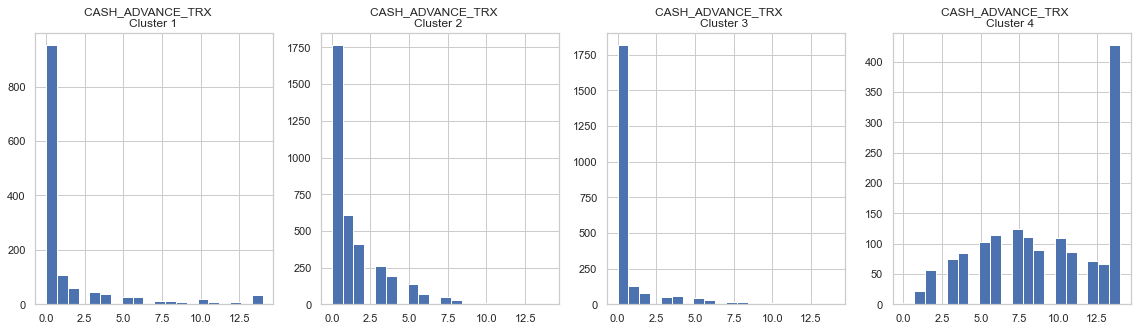

<Figure size 2520x360 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'PURCHASES_TRX    \nCluster 1 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'PURCHASES_TRX    \nCluster 2 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'PURCHASES_TRX    \nCluster 3 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'PURCHASES_TRX    \nCluster 4 ')

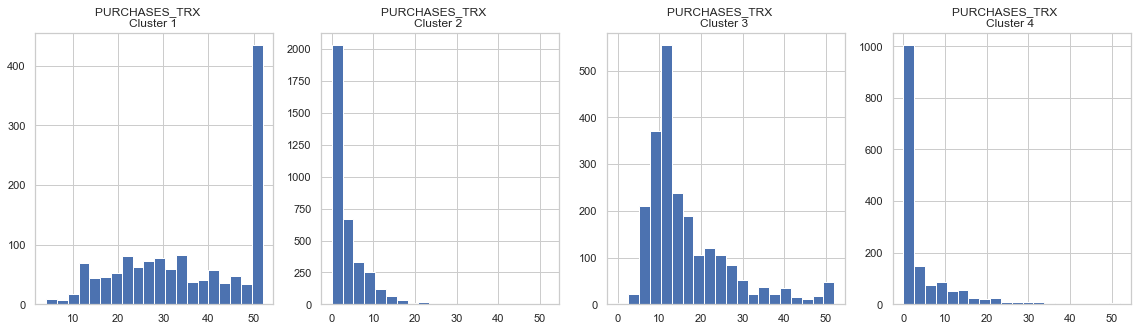

<Figure size 2520x360 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'CREDIT_LIMIT    \nCluster 1 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'CREDIT_LIMIT    \nCluster 2 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'CREDIT_LIMIT    \nCluster 3 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'CREDIT_LIMIT    \nCluster 4 ')

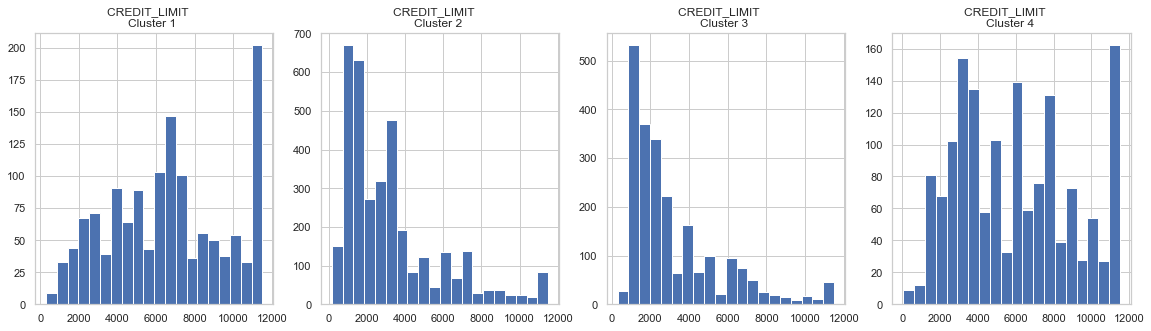

<Figure size 2520x360 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'PAYMENTS    \nCluster 1 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'PAYMENTS    \nCluster 2 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'PAYMENTS    \nCluster 3 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'PAYMENTS    \nCluster 4 ')

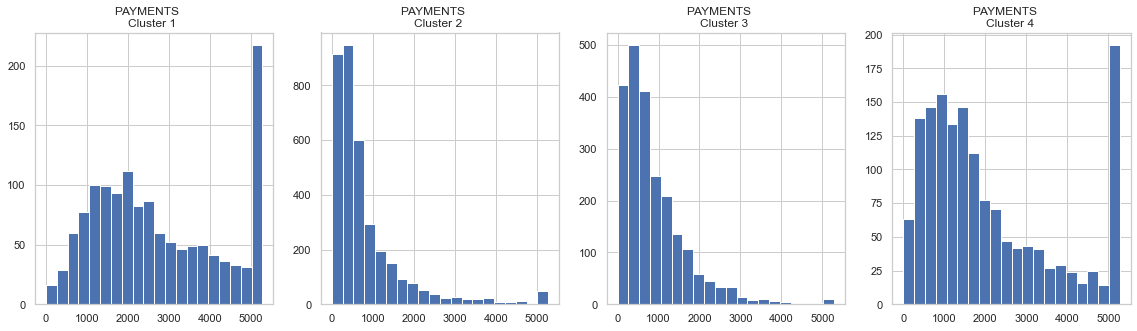

<Figure size 2520x360 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'MINIMUM_PAYMENTS    \nCluster 1 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'MINIMUM_PAYMENTS    \nCluster 2 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'MINIMUM_PAYMENTS    \nCluster 3 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'MINIMUM_PAYMENTS    \nCluster 4 ')

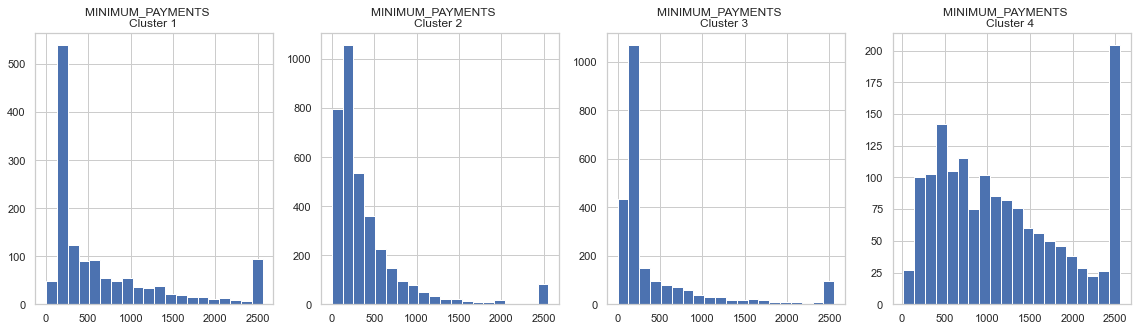

<Figure size 2520x360 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'PRC_FULL_PAYMENT    \nCluster 1 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'PRC_FULL_PAYMENT    \nCluster 2 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'PRC_FULL_PAYMENT    \nCluster 3 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'PRC_FULL_PAYMENT    \nCluster 4 ')

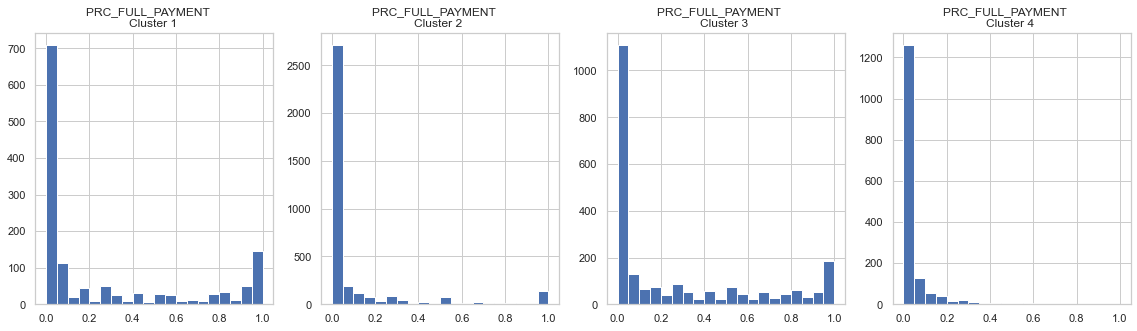

<Figure size 2520x360 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'TENURE    \nCluster 1 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'TENURE    \nCluster 2 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'TENURE    \nCluster 3 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'TENURE    \nCluster 4 ')

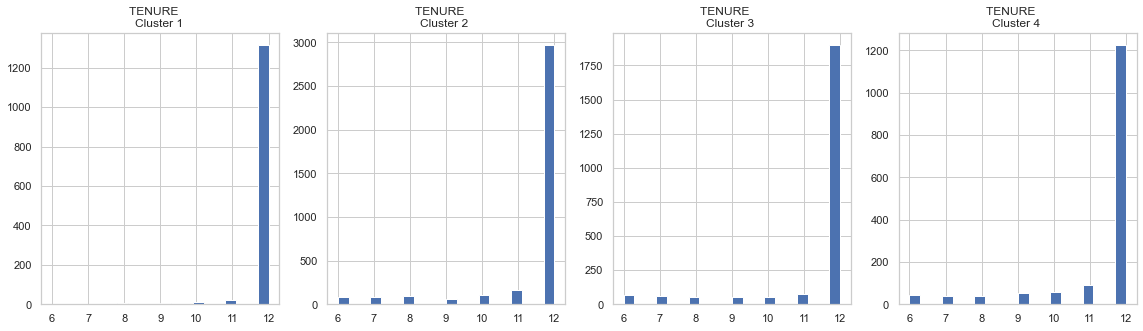

<Figure size 2520x360 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'cluster_kmeans    \nCluster 1 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'cluster_kmeans    \nCluster 2 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'cluster_kmeans    \nCluster 3 ')

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'cluster_kmeans    \nCluster 4 ')

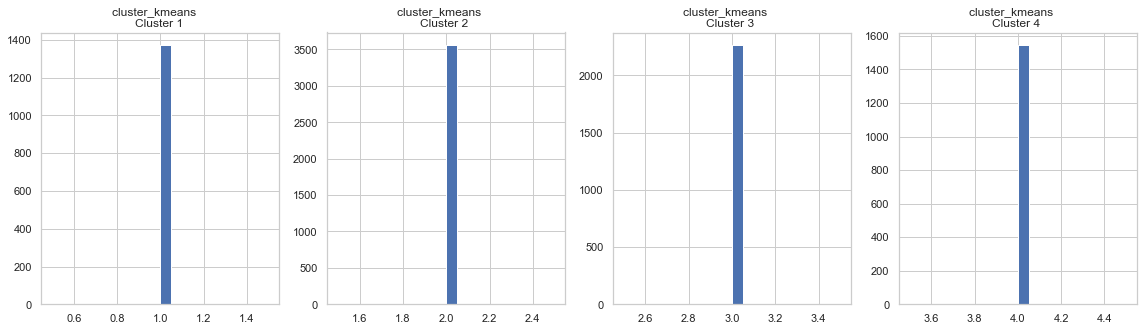

In [65]:
# Plot the histogram of various clusters
for i in credit.columns:
    plt.figure(figsize = (35, 5))
    for j in range(1,5):
        plt.subplot(1,7, j+1)
        cluster = credit[credit['cluster_kmeans'] == j]
        cluster[i].hist(bins = 20)
        plt.title('{}    \nCluster {} '.format(i,j))
  
    plt.show()

### Graficando los cluster con componentes principales

In [66]:
# PCA 2 dimensions

pca = PCA(n_components=2).fit(credit)
df_pca2 = pca.fit_transform(credit)
print("original shape:   ", credit.shape)
print("transformed shape:", df_pca2.shape)

original shape:    (8730, 18)
transformed shape: (8730, 2)


Text(0.5, 0, 'PC1')

Text(0, 0.5, 'PC2')

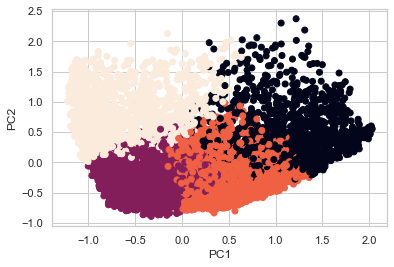

In [67]:
plt.scatter(dd[0], dd[1],c = KMeans(n_clusters=n_select, **dicc_kmeans).fit_predict(dd), cmap =None) 
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Text(0.5, 0, 'PC1')

Text(0, 0.5, 'PC3')

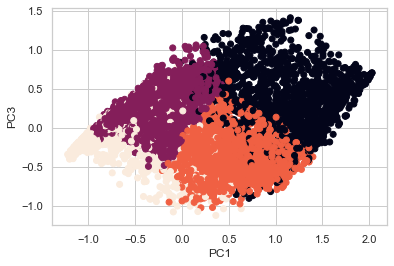

In [68]:
plt.scatter(dd[0], dd[2],c = KMeans(n_clusters=n_select, **dicc_kmeans).fit_predict(dd), cmap =None) 
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.show()

Text(0.5, 0, 'PC2')

Text(0, 0.5, 'PC3')

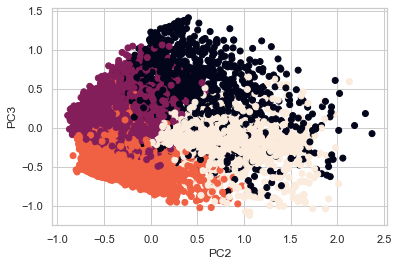

In [69]:
plt.scatter(dd[1], dd[2],c = KMeans(n_clusters=n_select, **dicc_kmeans).fit_predict(dd), cmap =None) 
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.show()

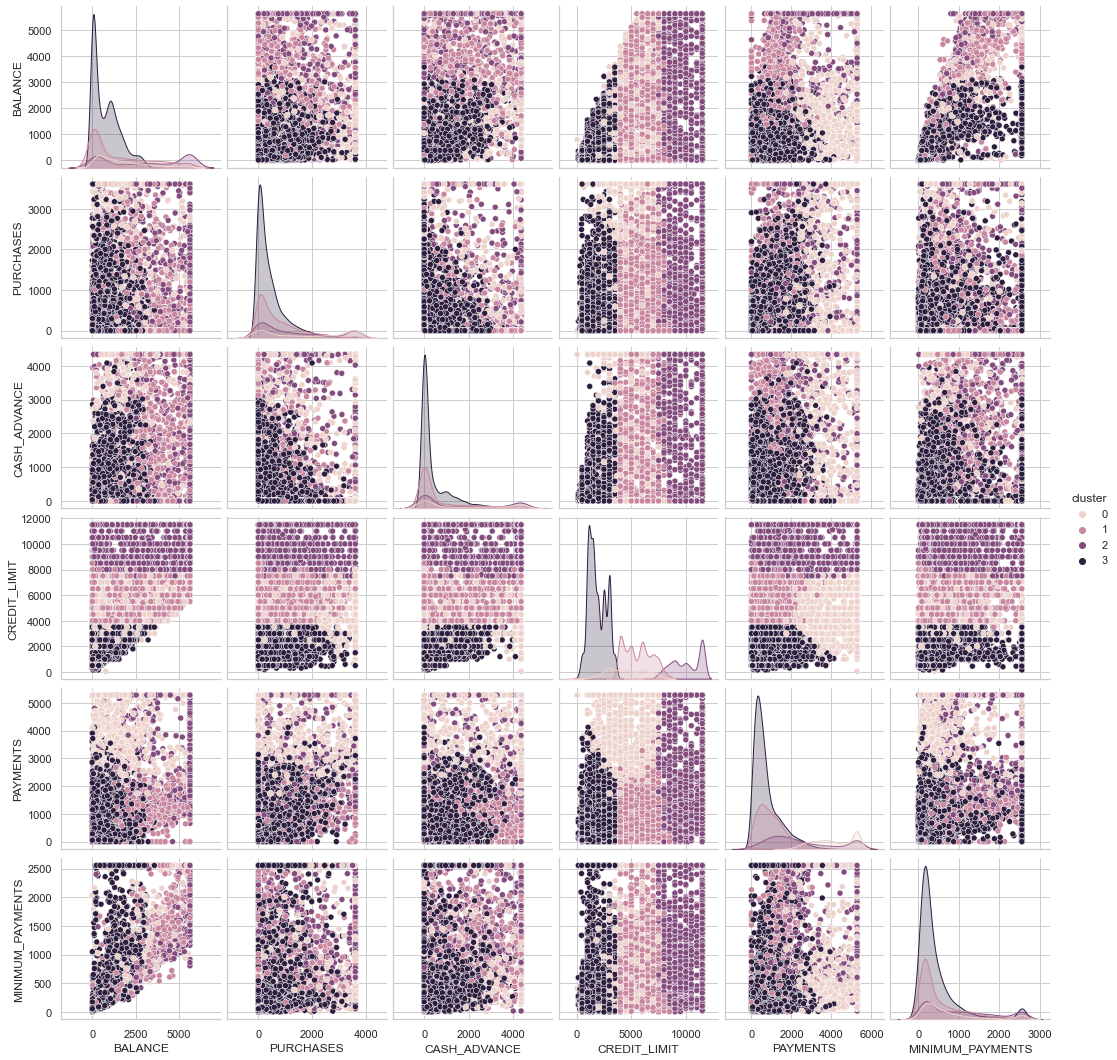

In [71]:
best_cols = ["BALANCE", "PURCHASES", "CASH_ADVANCE","CREDIT_LIMIT", "PAYMENTS", "MINIMUM_PAYMENTS"]
kmeans = KMeans(n_clusters=n_select, **dicc_kmeans)

best_vals = credit[best_cols].iloc[ :, 1:].values
y_pred = kmeans.fit_predict( best_vals )

credit["cluster"] = y_pred
best_cols.append("cluster")
sns.pairplot( credit[ best_cols ], hue="cluster", diag_kws={'bw': 0.2})

## >> Cluster jerarquico

In [72]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [75]:
siliuette_list_hierarchical = []

for cluster in range(2,20,2):
    for linkage_method in ['ward', 'average', 'complete']:
        agglomerative = AgglomerativeClustering(linkage=linkage_method, affinity='euclidean',n_clusters=cluster).fit_predict(dd)
        sil_score = silhouette_score(dd, agglomerative, metric='euclidean')
        siliuette_list_hierarchical.append((cluster, sil_score, linkage_method, len(set(agglomerative)) ) )
        
df_hierarchical = pd.DataFrame(siliuette_list_hierarchical, columns=['cluster', 'sil_score','linkage_method', 'number_of_clusters'])

In [76]:
df_hierarchical.sort_values('sil_score', ascending=False)

,cluster,sil_score,linkage_method,number_of_clusters
1,2,0.341816,average,2
0,2,0.337620,ward,2
2,2,0.315887,complete,2
10,8,0.284842,average,8
4,4,0.280477,average,4
13,10,0.265003,average,10
3,4,0.263956,ward,4
16,12,0.251493,average,12
19,14,0.243173,average,14
7,6,0.239582,average,6


In [77]:
hierarchical_= AgglomerativeClustering(
    linkage='average', 
    affinity='euclidean', 
    n_clusters=n_select
).fit_predict(dd)  ## Change 4 ----- OJOOOOOOOOOOOOOOOOO

In [107]:
Hierarchical_Silhouette_Score = silhouette_score(dd, hierarchical_, metric='euclidean')
Hierarchical_Silhouette_Score

0.28047677919529956

In [108]:
credit['cluster_hierarchical'] = hierarchical_ 

In [109]:
credit["cluster_hierarchical"] = credit["cluster_hierarchical"] + 1
credit.groupby("cluster_hierarchical").agg({"cluster_hierarchical": "count"})

,cluster_hierarchical
cluster_hierarchical,
1,1700
2,6228
3,6
4,796


<Figure size 1440x720 with 0 Axes>

Text(0.5, 1.0, 'Hierarchical Clustering')

Text(0.5, 0, 'Observations')

Text(0, 0.5, 'Distance')

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [35.0, 35.0, 45.0, 45.0],
  [20.0, 20.0, 40.0, 40.0],
  [5.0, 5.0, 30.0, 30.0],
  [55.0, 55.0, 65.0, 65.0],
  [75.0, 75.0, 85.0, 85.0],
  [60.0, 60.0, 80.0, 80.0],
  [95.0, 95.0, 105.0, 105.0],
  [115.0, 115.0, 125.0, 125.0],
  [100.0, 100.0, 120.0, 120.0],
  [70.0, 70.0, 110.0, 110.0],
  [17.5, 17.5, 90.0, 90.0],
  [135.0, 135.0, 145.0, 145.0],
  [155.0, 155.0, 165.0, 165.0],
  [140.0, 140.0, 160.0, 160.0],
  [175.0, 175.0, 185.0, 185.0],
  [195.0, 195.0, 205.0, 205.0],
  [180.0, 180.0, 200.0, 200.0],
  [150.0, 150.0, 190.0, 190.0],
  [215.0, 215.0, 225.0, 225.0],
  [235.0, 235.0, 245.0, 245.0],
  [220.0, 220.0, 240.0, 240.0],
  [255.0, 255.0, 265.0, 265.0],
  [275.0, 275.0, 285.0, 285.0],
  [260.0, 260.0, 280.0, 280.0],
  [230.0, 230.0, 270.0, 270.0],
  [170.0, 170.0, 250.0, 250.0],
  [53.75, 53.75, 210.0, 210.0],
  [295.0, 295.0, 305.0, 305.0],
  [315.0, 315.0, 325.0, 325.0],
  [300.0, 300.0, 320.0, 320.0],
  [335.0, 335.0, 345.0, 345.0],
  [3

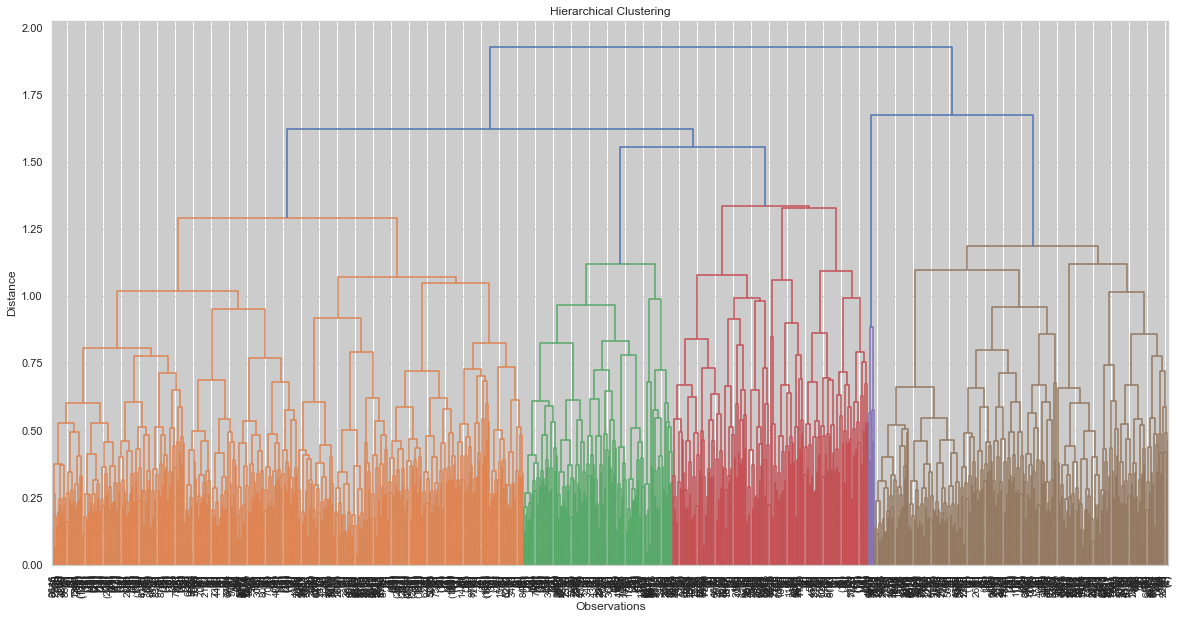

In [110]:
#### Cluster jerarquico 2
# Average Linkage Method
hc_average = linkage(dd, "average")

plt.figure(figsize=(20, 10))
plt.title("Hierarchical Clustering")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_average,
           leaf_font_size=10, 
           p=10,
           show_contracted=True,
          truncate_mode='level')
plt.show()

<Figure size 1080x720 with 0 Axes>

Text(0.5, 1.0, 'Hierarchical Clustering')

Text(0.5, 0, 'Observations')

Text(0, 0.5, 'Distance')

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [5.0, 5.0, 22.5, 22.5],
  [45.0, 45.0, 55.0, 55.0],
  [85.0, 85.0, 95.0, 95.0],
  [75.0, 75.0, 90.0, 90.0],
  [65.0, 65.0, 82.5, 82.5],
  [50.0, 50.0, 73.75, 73.75],
  [13.75, 13.75, 61.875, 61.875]],
 'dcoord': [[0.0, 2.333559986704538, 2.333559986704538, 0.0],
  [0.0, 2.5509123426697267, 2.5509123426697267, 2.333559986704538],
  [0.0, 3.1003341372946083, 3.1003341372946083, 2.5509123426697267],
  [0.0, 2.7070657336996695, 2.7070657336996695, 0.0],
  [0.0, 2.389891881550941, 2.389891881550941, 0.0],
  [0.0, 2.680955199991903, 2.680955199991903, 2.389891881550941],
  [0.0, 3.055928899134069, 3.055928899134069, 2.680955199991903],
  [2.7070657336996695,
   3.1277788901157564,
   3.1277788901157564,
   3.055928899134069],
  [3.1003341372946083,
   3.672417100699651,
   3.672417100699651,
   3.1277788901157564]],
 'ivl': ['(1536)',
  '(2190)',
  '(2164)',
  '(632)',
  '(226)',
  '(1135)',
  '(518)',
  '(73)',
  '(124)',
 

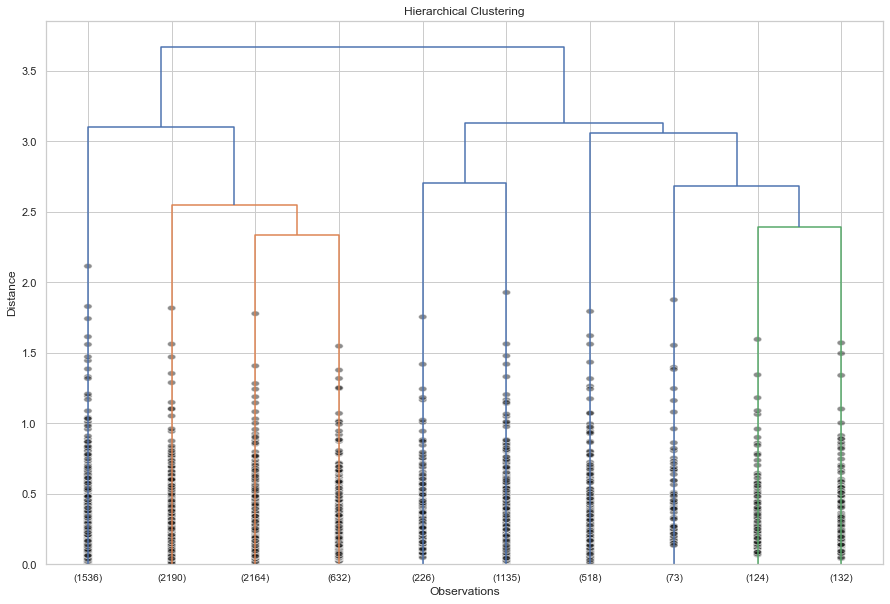

In [111]:
# Complete Linkage Method
hc_complete = linkage(dd, "complete")

plt.figure(figsize=(15, 10))
plt.title("Hierarchical Clustering")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_complete,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.show()

## DBSCAN

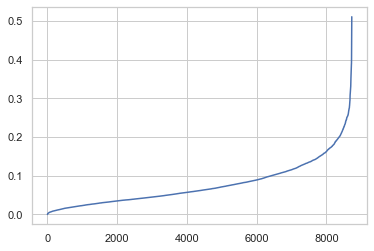

In [80]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=n_select)
nbrs = neigh.fit(dd)
distances, indices = nbrs.kneighbors(dd)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [82]:
from sklearn.cluster import DBSCAN

siliuette_list_dbscan = []

for eps in np.arange(0.01,0.15,0.01):
    for min_sample in range(2, 8):
        dbscan = DBSCAN(eps=eps, min_samples= min_sample)
        dbscan.fit(dd)
        sil_score = silhouette_score(dd, dbscan.labels_, metric='euclidean')
        siliuette_list_dbscan.append((eps, min_sample, sil_score, len(set(dbscan.labels_))) )
        
df_dbscan = pd.DataFrame(siliuette_list_dbscan, columns=['eps', 'min_samples', 'sil_score', 'number_of_clusters'])

DBSCAN(eps=0.01, min_samples=2)

DBSCAN(eps=0.01, min_samples=3)

DBSCAN(eps=0.01, min_samples=4)

DBSCAN(eps=0.01)

DBSCAN(eps=0.01, min_samples=6)

DBSCAN(eps=0.01, min_samples=7)

DBSCAN(eps=0.02, min_samples=2)

DBSCAN(eps=0.02, min_samples=3)

DBSCAN(eps=0.02, min_samples=4)

DBSCAN(eps=0.02)

DBSCAN(eps=0.02, min_samples=6)

DBSCAN(eps=0.02, min_samples=7)

DBSCAN(eps=0.03, min_samples=2)

DBSCAN(eps=0.03, min_samples=3)

DBSCAN(eps=0.03, min_samples=4)

DBSCAN(eps=0.03)

DBSCAN(eps=0.03, min_samples=6)

DBSCAN(eps=0.03, min_samples=7)

DBSCAN(eps=0.04, min_samples=2)

DBSCAN(eps=0.04, min_samples=3)

DBSCAN(eps=0.04, min_samples=4)

DBSCAN(eps=0.04)

DBSCAN(eps=0.04, min_samples=6)

DBSCAN(eps=0.04, min_samples=7)

DBSCAN(eps=0.05, min_samples=2)

DBSCAN(eps=0.05, min_samples=3)

DBSCAN(eps=0.05, min_samples=4)

DBSCAN(eps=0.05)

DBSCAN(eps=0.05, min_samples=6)

DBSCAN(eps=0.05, min_samples=7)

DBSCAN(eps=0.060000000000000005, min_samples=2)

DBSCAN(eps=0.060000000000000005, min_samples=3)

DBSCAN(eps=0.060000000000000005, min_samples=4)

DBSCAN(eps=0.060000000000000005)

DBSCAN(eps=0.060000000000000005, min_samples=6)

DBSCAN(eps=0.060000000000000005, min_samples=7)

DBSCAN(eps=0.06999999999999999, min_samples=2)

DBSCAN(eps=0.06999999999999999, min_samples=3)

DBSCAN(eps=0.06999999999999999, min_samples=4)

DBSCAN(eps=0.06999999999999999)

DBSCAN(eps=0.06999999999999999, min_samples=6)

DBSCAN(eps=0.06999999999999999, min_samples=7)

DBSCAN(eps=0.08, min_samples=2)

DBSCAN(eps=0.08, min_samples=3)

DBSCAN(eps=0.08, min_samples=4)

DBSCAN(eps=0.08)

DBSCAN(eps=0.08, min_samples=6)

DBSCAN(eps=0.08, min_samples=7)

DBSCAN(eps=0.09, min_samples=2)

DBSCAN(eps=0.09, min_samples=3)

DBSCAN(eps=0.09, min_samples=4)

DBSCAN(eps=0.09)

DBSCAN(eps=0.09, min_samples=6)

DBSCAN(eps=0.09, min_samples=7)

DBSCAN(eps=0.09999999999999999, min_samples=2)

DBSCAN(eps=0.09999999999999999, min_samples=3)

DBSCAN(eps=0.09999999999999999, min_samples=4)

DBSCAN(eps=0.09999999999999999)

DBSCAN(eps=0.09999999999999999, min_samples=6)

DBSCAN(eps=0.09999999999999999, min_samples=7)

DBSCAN(eps=0.11, min_samples=2)

DBSCAN(eps=0.11, min_samples=3)

DBSCAN(eps=0.11, min_samples=4)

DBSCAN(eps=0.11)

DBSCAN(eps=0.11, min_samples=6)

DBSCAN(eps=0.11, min_samples=7)

DBSCAN(eps=0.12, min_samples=2)

DBSCAN(eps=0.12, min_samples=3)

DBSCAN(eps=0.12, min_samples=4)

DBSCAN(eps=0.12)

DBSCAN(eps=0.12, min_samples=6)

DBSCAN(eps=0.12, min_samples=7)

DBSCAN(eps=0.13, min_samples=2)

DBSCAN(eps=0.13, min_samples=3)

DBSCAN(eps=0.13, min_samples=4)

DBSCAN(eps=0.13)

DBSCAN(eps=0.13, min_samples=6)

DBSCAN(eps=0.13, min_samples=7)

DBSCAN(eps=0.14, min_samples=2)

DBSCAN(eps=0.14, min_samples=3)

DBSCAN(eps=0.14, min_samples=4)

DBSCAN(eps=0.14)

DBSCAN(eps=0.14, min_samples=6)

DBSCAN(eps=0.14, min_samples=7)

In [83]:
df_dbscan.sort_values('sil_score', ascending=False).head()

,eps,min_samples,sil_score,number_of_clusters
3,0.01,5,-0.197975,3
4,0.01,6,-0.198989,3
5,0.01,7,-0.199387,3
11,0.02,7,-0.225255,5
2,0.01,4,-0.285249,6


## Clarans

In [85]:
#!pip install pyclustering

In [86]:
from pyclustering.cluster.clarans import clarans

In [87]:
#Data a Lista:
X = dd.sample(n=100, replace=False)
X_list =X.iloc[:, :].values

In [88]:
#numlocal: Número de interaciones para que converga
#maxneighbor : Maximo número de vecinos

from pyclustering.utils import timedcall

M_Clarans= clarans(X_list, number_clusters=4,numlocal=6, maxneighbor=4)

#calls the clarans method 'process' to implement the algortihm
(ticks, result) = timedcall(M_Clarans.process);
print("Execution time : ", ticks, "\n");

Execution time :  5.797888900000544 



In [89]:
clusters = M_Clarans.get_clusters()
print("Index of the points that are in a cluster : ",clusters)

Index of the points that are in a cluster :  [[32, 41, 43, 99], [2, 5, 11, 14, 21, 27, 28, 45, 48, 53, 55, 57, 61, 76, 81, 85, 88, 92], [4, 7, 8, 9, 10, 12, 16, 18, 20, 23, 25, 26, 29, 30, 33, 34, 38, 39, 40, 44, 46, 47, 49, 50, 59, 64, 65, 66, 67, 68, 69, 71, 72, 73, 75, 77, 82, 83, 84, 87, 89, 91, 93, 94, 95, 96], [0, 1, 3, 6, 13, 15, 17, 19, 22, 24, 31, 35, 36, 37, 42, 51, 52, 54, 56, 58, 60, 62, 63, 70, 74, 78, 79, 80, 86, 90, 97, 98]]


In [90]:
cluster_1=pd.DataFrame(X.iloc[clusters[0],:])
cluster_1['Cluster']=1

cluster_2=pd.DataFrame(X.iloc[clusters[1],:])
cluster_2['Cluster']=2

cluster_3=pd.DataFrame(X.iloc[clusters[2],:])
cluster_3['Cluster']=3

cluster_4=pd.DataFrame(X.iloc[clusters[3],:])
cluster_4['Cluster']=4

In [91]:
data_final=pd.concat([cluster_1,cluster_2,cluster_3,cluster_4])
data_final.groupby(['Cluster'])['Cluster'].count()

Cluster
1     4
2    18
3    46
4    32
Name: Cluster, dtype: int64

## K_medois parte 2

In [92]:
#!pip install https://github.com/scikit-learn-contrib/scikit-learn-extra/archive/master.zip

In [93]:
#!pip install scikit-learn-extra

In [94]:
from sklearn_extra.cluster import KMedoids

kMedoids = KMedoids(n_clusters = 4, random_state = 0)
kMedoids.fit(dd)
y_kmed = kMedoids.fit_predict(dd)

KMedoids(n_clusters=4, random_state=0)

In [95]:
y_kmed

array([2, 0, 3, ..., 1, 2, 2], dtype=int64)

In [96]:
kMedoids.inertia_

5067.053215671107

In [97]:
from sklearn.metrics import silhouette_samples, silhouette_score
kMedoids = KMedoids(n_clusters = 4, random_state = 0)
kMedoids.fit(dd)
y_kmed = kMedoids.fit_predict(dd)
silhouette_avg = silhouette_score(dd, y_kmed)
print(silhouette_avg)

KMedoids(n_clusters=4, random_state=0)

0.33358704084847973


In [98]:
sample_silhouette_values = silhouette_samples(dd, y_kmed)
for i in range(4):
    ith_cluster_silhouette_values = sample_silhouette_values[y_kmed == i]
    print(np.mean(ith_cluster_silhouette_values))

0.27684972949662356
0.3665139762217378
0.42116342091342474
0.16829396964533047


In [99]:
sw = []

for i in range(2, 11):
    kMedoids = KMedoids(n_clusters = i, random_state = SEED)
    kMedoids.fit(dd)
    y_kmed = kMedoids.fit_predict(dd)
    silhouette_avg = silhouette_score(dd, y_kmed)
    sw.append(silhouette_avg)
    

KMedoids(n_clusters=2, random_state=0)

KMedoids(n_clusters=3, random_state=0)

KMedoids(n_clusters=4, random_state=0)

KMedoids(n_clusters=5, random_state=0)

KMedoids(n_clusters=6, random_state=0)

KMedoids(n_clusters=7, random_state=0)

KMedoids(random_state=0)

KMedoids(n_clusters=9, random_state=0)

KMedoids(n_clusters=10, random_state=0)

Text(0.5, 1.0, 'Silhoute Score')

Text(0.5, 0, 'Número de clusters')

Text(0, 0.5, 'Silhoute Score')

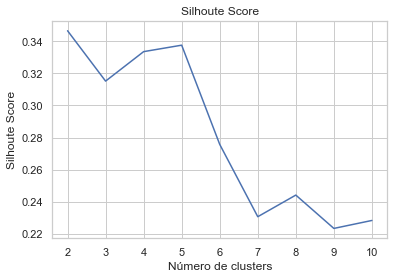

In [101]:
plt.plot(range(2, 11), sw)
plt.title('Silhoute Score')
plt.xlabel('Número de clusters')
plt.ylabel('Silhoute Score')      #within cluster sum of squares
plt.show()

### Spectral Clustering

In [102]:
from sklearn.cluster import SpectralClustering 
# Building the clustering model 
spectral_model_rbf = SpectralClustering(n_clusters = 4, affinity ='rbf') 
  
# Training the model and Storing the predicted cluster labels 
labels_rbf = spectral_model_rbf.fit_predict(dd)

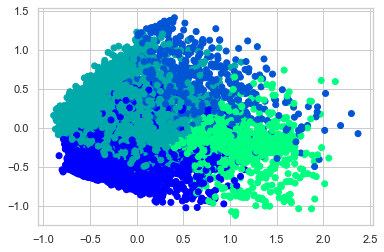

In [103]:
# Visualizing the clustering 
plt.scatter(dd[1], dd[2],  
           c = SpectralClustering(n_clusters = 4, affinity ='rbf') .fit_predict(dd), cmap =plt.cm.winter) 
plt.show() 

In [104]:
from sklearn.cluster import SpectralClustering 
# Building the clustering model 
spectral_model_nn = SpectralClustering(n_clusters = 4, affinity ='nearest_neighbors') 
  
# Training the model and Storing the predicted cluster labels 
labels_nn = spectral_model_rbf.fit_predict(dd)

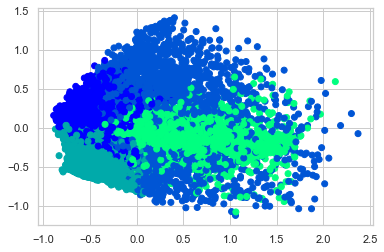

In [105]:
# Visualizing the clustering 
plt.scatter(dd[1], dd[2],  
           c = SpectralClustering(n_clusters = 4, affinity ='nearest_neighbors') .fit_predict(dd), cmap =plt.cm.winter) 
plt.show() 

<BarContainer object of 2 artists>

Text(0.5, 0, 'Affinity')

Text(0, 0.5, 'Silhouette Score')

Text(0.5, 1.0, 'Comparison of different Clustering Models')

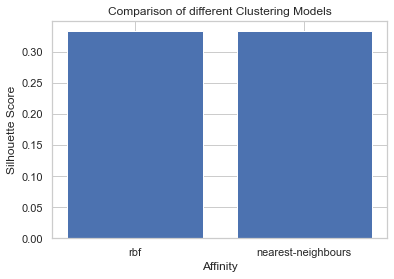

[0.3331890371480688, 0.33322937202535485]


In [106]:
# List of different values of affinity 
affinity = ['rbf', 'nearest-neighbours'] 
  
# List of Silhouette Scores 
s_scores = [] 
  
# Evaluating the performance 
s_scores.append(silhouette_score(dd, labels_rbf)) 
s_scores.append(silhouette_score(dd, labels_nn)) 
  
# Plotting a Bar Graph to compare the models 
plt.bar(affinity, s_scores) 
plt.xlabel('Affinity') 
plt.ylabel('Silhouette Score') 
plt.title('Comparison of different Clustering Models') 
plt.show() 

print(s_scores)

## >> Cluster seleccionados

## KMEANS

In [128]:
modelo_kmeans = KMeans(n_clusters=4, **dicc_kmeans)
cluster_labels = modelo_kmeans.fit_predict(dd)
silhouette_avg = silhouette_score(dd, cluster_labels)

print('silueta: ', silhouette_avg)

silueta:  0.34881725349049714


In [129]:
clusters = modelo_kmeans.labels_

pd.DataFrame({"Customers": credit.index, "Clusters": clusters})
credit["cluster_kmeans"] = clusters
credit.head()

,Customers,Clusters
0,0,1
1,1,3
2,2,0
3,3,1
4,4,1
...,...,...
8725,8725,2
8726,8726,2
8727,8727,2
8728,8728,1


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster_kmeans,cluster,cluster_hierarchical
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0.0,2.0,1000.0,201.802084,139.509787,0.000000,12.0,1,3,2
1,3202.467416,0.909091,0.00,0.00,0.0,4340.861877,0.000000,0.000000,0.000000,0.250000,4.0,0.0,7000.0,4103.032597,1072.340217,0.222222,12.0,3,0,1
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,12.0,7500.0,622.066742,627.284787,0.000000,12.0,0,1,2
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1.0,1.0,7500.0,0.000000,448.208854,0.000000,12.0,1,1,2
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0.0,1.0,1200.0,678.334763,244.791237,0.000000,12.0,1,3,2


** Se aprecia proporcion equilibrada entre la cantidad de registros por cluster **

In [130]:
credit.groupby("cluster_kmeans").agg(
    {"cluster_kmeans": "count"}
)

,cluster_kmeans
cluster_kmeans,
0,1370
1,3555
2,2262
3,1543


In [131]:
credit.groupby(by=['cluster_kmeans']).mean()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster,cluster_hierarchical
cluster_kmeans,,,,,,,,,,,,,,,,,,,
0,1842.448272,0.977103,2595.390620,1657.406004,796.771321,444.557104,0.918810,0.698173,0.631435,0.070800,1.489051,35.712409,6643.052422,2763.064947,695.613649,0.264954,11.894161,1.300000,3.041606
1,871.996448,0.784865,287.720415,234.270366,51.573551,389.872539,0.200525,0.122358,0.076910,0.083230,1.396906,3.430380,3211.209734,808.830501,401.909038,0.089459,11.484669,2.423347,1.983404
2,613.734626,0.903936,769.645126,134.550416,599.334146,175.986802,0.871525,0.085783,0.810927,0.038291,0.701149,16.627321,3183.859930,889.625961,439.921986,0.267854,11.438550,2.368258,1.953581
3,3280.134871,0.957375,282.282552,187.175852,92.045221,2819.173561,0.201229,0.097880,0.114268,0.398535,9.206092,4.190538,5931.446022,2100.685610,1195.106696,0.030540,11.370706,1.587168,1.115360
